In this notebook we will train a basic keras neural network.

The dataset will be small and use very little feature engineering.

The prediction target will be 0 or 1.
* 0 = the player did not win the race
* 1 = the player won the race

We will save the model along with the dummies and scaling params.

We will then load the model and apply it to the validation data.

Finally we will graph the betting results based on the predictions.

In [1]:
import pandas as pd
import numpy as np
import tensorflow

from cataclop.core import models
from cataclop.ml.preprocessing import append_hist, model_to_dict
from cataclop.ml.preprocessing import get_dummies, get_dummy_values, get_dummy_features
from cataclop.ml.exploration import random_race

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

Load up to 1000 races from the database

In [2]:
races = models.Race.objects.all().prefetch_related('player_set', 'session', 'session__hippodrome')

# let's filter french handicap races of 2018 and 2019
races = races.filter(
    #session__hippodrome__country__in=('FRA',),
    #category__in=('PLAT',),
    #sub_category__in=('HANDICAP',),
    start_at__gte='2021-01-01',
    start_at__lt='2021-02-01'
)

races = races[:100000]

hippodromes = models.Hippodrome.objects.all()
hippodromes = [ model_to_dict(hippo) for hippo in hippodromes ]

sessions = [race.session for race in races]
sessions = list( map(lambda s: model_to_dict(s), set(sessions)) )

def player_dict(p):
    d = model_to_dict(p)
    d.update({
        "horse_name": p.horse.name,
        "horse_breed": p.horse.breed,
        "horse_sex": p.horse.sex
    })
    return d
players = [ player_dict(p) for race in races for p in race.player_set.all() ]

races = [ model_to_dict(race) for race in races ]

print('{} races'.format(len(races)))

1322 races


Construct the dataframe

In [3]:
races_df = pd.DataFrame.from_records(races, index='id')
sessions_df = pd.DataFrame.from_records(sessions, index='id')
hippodromes_df = pd.DataFrame.from_records(hippodromes, index='id')
players_df = pd.DataFrame.from_records(players, index='id')

hippodromes_df.index.name = "hippodrome_id"
sessions_df.index.name = "session_id"
races_df.index.name = "race_id"

# optimize a bit the dataframe
for c in ['horse_breed', 'horse_sex']:
    players_df[c] = players_df[c].astype('category')

for c in ['category', 'condition_age', 'condition_sex', 'sub_category']:
    races_df[c] = races_df[c].astype('category')

for c in ['country']:
    hippodromes_df[c] = hippodromes_df[c].astype('category')

# join all the dataframes into one
sessions_df = sessions_df.join(hippodromes_df, on="hippodrome_id", lsuffix="_session", rsuffix="_hippo")
races_df = races_df.join(sessions_df, on="session_id", lsuffix="_race", rsuffix="_session")

df = players_df.join(races_df, on="race_id", lsuffix="_player", rsuffix="_race")

df.reset_index(inplace=True)
df.set_index(['id'], inplace=True)

df['winner_dividend'].fillna(0., inplace=True)
df['placed_dividend'].fillna(0., inplace=True)

NUM_HIST = 6
# append 6 columns of position history (hist_1_pos, hist_2_pos...)
# parse the horse 'musique' into those columns
# eg. '1a4a7d0' : hist_1_pos=1, hist_2_pos=4, hist_3_pos=7, hist_4_pos=10
df = append_hist(df, NUM_HIST)

df['victory_earnings'] = np.log(1+df['victory_earnings'].fillna(0))
df['placed_earnings'] = np.log(1+df['placed_earnings'].fillna(0))
df['prev_year_earnings'] = np.log(1+df['prev_year_earnings'].fillna(0))
df['year_earnings'] = np.log(1+df['year_earnings'].fillna(0))
df['prize'] = np.log(df['prize'].fillna(0)+1)

df['handicap_distance'] = df['handicap_distance'].fillna(0.0)
df['handicap_weight'] = df['handicap_weight'].fillna(0.0)
df['win'] = (df['position'] == 1).astype(np.float)

In [4]:
sorted(list(df.columns))

['age',
 'category',
 'code',
 'condition_age',
 'condition_sex',
 'country',
 'date',
 'declared_player_count',
 'distance',
 'earnings',
 'final_odds',
 'final_odds_offline',
 'final_odds_ref',
 'final_odds_ref_offline',
 'final_odds_ref_unibet',
 'final_odds_unibet',
 'handicap_distance',
 'handicap_weight',
 'herder_avg_winning_dividend',
 'herder_id',
 'herder_winning_rate',
 'hippodrome_id',
 'hist_1_days',
 'hist_1_pos',
 'hist_2_days',
 'hist_2_pos',
 'hist_3_days',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'horse_breed',
 'horse_id',
 'horse_name',
 'horse_sex',
 'imported_at_hippo',
 'imported_at_player',
 'imported_at_race',
 'imported_at_session',
 'is_first_timer',
 'is_racing',
 'jockey_avg_winning_dividend',
 'jockey_change',
 'jockey_id',
 'jockey_winning_rate',
 'music',
 'name',
 'num',
 'num_bis',
 'num_race',
 'num_session',
 'owner_id',
 'placed_2_count',
 'placed_3_count',
 'placed_count',
 'placed_dividend',
 'placed_dividend_offline',
 'placed

In [5]:
df.describe()

,race_id,age,num,race_count,victory_count,placed_count,placed_2_count,placed_3_count,earnings,victory_earnings,placed_earnings,year_earnings,prev_year_earnings,post_position,position,handicap_weight,handicap_distance,trueskill_mu,trueskill_sigma,time,hist_1_days,hist_2_days,hist_3_days,winner_dividend,placed_dividend,final_odds,final_odds_offline,final_odds_unibet,final_odds_ref,final_odds_ref_offline,final_odds_ref_unibet,trainer_winning_rate,trainer_avg_winning_dividend,horse_id,trainer_id,jockey_id,herder_id,owner_id,num_race,num_bis,prize,distance,declared_player_count,session_id,num_session,hippodrome_id,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,win
count,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,1.596500e+04,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,12762.000000,15965.000000,15965.000000,15965.000000,15965.000000,5543.000000,3686.000000,580.000000,59.000000,15965.000000,15965.000000,15638.000000,12045.000000,14900.000000,15045.000000,11536.000000,14932.000000,12790.000000,12790.000000,15965.000000,15965.000000,15965.000000,10156.000000,15965.000000,15965.000000,1261.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000,15965.000000
mean,655.999937,5.561353,6.916317,24.382336,2.684685,10.617413,2.534168,2.384341,6.563772e+06,13.682499,11.649797,3.136052,10.764135,6.916317,5.861856,10.664579,1233.414344,25.158988,7.100542,195685.515064,12.136734,18.087931,21.813559,70.419042,72.434075,33.504786,34.136306,30.989839,24.144905,22.653450,27.105391,0.082549,-0.280413,5347.393486,857.651989,687.350642,1118.386963,2722.651550,4.877231,1.762887,9.668022,2181.362668,12.832634,95.323833,3.523019,15.235954,6.272972,5.945506,5.686940,5.003069,3.970122,3.367742,0.082242
std,383.020154,1.862862,4.049526,26.469777,3.388455,11.794345,3.112589,2.943889,1.375487e+07,4.134910,5.613142,5.451706,5.910035,4.049526,3.546344,16.475917,1300.725431,3.950268,2.211882,26942.929276,5.638333,5.061029,4.183195,405.321321,191.615665,48.193140,43.208026,39.553740,33.453339,24.000108,34.197496,0.156142,2.141056,3415.399644,725.175253,555.417193,908.818094,2098.225265,2.536990,0.772598,1.100038,729.140942,2.876507,55.398042,1.910796,13.245377,3.275407,3.396984,3.494307,3.717243,3.909612,3.815709,0.274742
min,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.529207,1.038827,24980.000000,1.000000,2.000000,13.000000,0.000000,0.000000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,0.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.459904,800.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,323.000000,4.000000,4.000000,5.000000,0.000000,2.000000,0.000000,0.000000,6.852000e+05,13.437468,11.931642,0.000000,10.926658,4.000000,3.000000,0.000000,0.000000,25.000000,8.333333,168440.000000,8.000000,15.000000,19.000000,0.000000,0.000000,7.400000,7.700000,7.300000,7.700000,8.100000,7.600000,0.000000,-1.000000,2384.000000,253.000000,219.000000,356.000000,885.000000,3.000000,1.000000,9.049819,1600.000000,11.000000,47.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,650.000000,5.000000,7.000000,16.000000,2.000000,7.000000,2.000000,1.000000,2.553000e+06,14.752780,13.907179,0.000000,13.503537,7.000000,5.000000,0.000000,0.000000,25.000000,8.333333,204550.000000,12.000000,18.000000,22.000000,0.000000,0.000000,16.000000,17.000000,15.800000,14.000000,15.000000,15.100000,0.000000,-1.000000,5056.000000,686.000000,600.000000,861.000000,2251.000000,5.000000,2.000000,9.798183,2150.000000,13.000000,95.000000,3.000000,14.000000,6.000000,6.000000,6.000000,5.000000,3.000000,2.000000,0.000000
75%,985.000000,7.000000,10.000000,35

Define the target and the features to feed our model 

In [6]:
TARGET = 'win'

FEATURES = [
    'race_count',
    'victory_count',
    'placed_count',
    'placed_2_count',
    'placed_3_count',
    'prize',
    'declared_player_count', 
    'age', 
    'earnings',
    'victory_earnings', 
    'placed_earnings', 
    'post_position',
    'handicap_weight',
    'handicap_distance'
] + ['hist_{}_pos'.format(h+1) for h in range(NUM_HIST)]

CATEGORICAL_FEATURES = [
    'category', 
    'sub_category', 
    'horse_breed',
    'horse_sex'
]

# a good practice before fine tuning the model is to inject the target into the features
# the model should pick it up and get REALLY good predictions
# uncomment the following line to test it
# FEATURES += [TARGET]

FEATURES + CATEGORICAL_FEATURES

['race_count',
 'victory_count',
 'placed_count',
 'placed_2_count',
 'placed_3_count',
 'prize',
 'declared_player_count',
 'age',
 'earnings',
 'victory_earnings',
 'placed_earnings',
 'post_position',
 'handicap_weight',
 'handicap_distance',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'category',
 'sub_category',
 'horse_breed',
 'horse_sex']

Show selected features for one race

In [7]:
random_race(df, [TARGET, 'num', 'final_odds', 'music', 'position'] + FEATURES + CATEGORICAL_FEATURES).sort_values('position')

win  num  final_odds                     music  position  \
race_id id                                                               
380     4702  1.0    3         4.0      (20)2p8p0p3p6p2p2p1p       1.0   
        4703  0.0    4         9.9  (20)1p2p3p9h0p6p(19)1p3p       2.0   
        4708  0.0    9         4.1  (20)5p4p2p4p2p6p(19)1p1p       3.0   
        4701  0.0    2         9.3    (20)5p2p7p4p6p7p0p4p8p       4.0   
        4704  0.0    5         9.2  (20)7p3p(19)8p8p3p1p1p1p       5.0   
        4707  0.0    8         5.0  (20)6p5p9p9p0p(19)0p7p4p       6.0   
        4700  0.0    1        14.0    (20)0p7p6p9p2p4p4p0p9p       7.0   
        4705  0.0    6        31.0  (20)9p4p1p7p9p9p(19)4p5p       8.0   
        4706  0.0    7        53.0  (20)0p7pTp4p9p2p0p(19)6p       9.0   
        4713  0.0   14       144.0    (20)0p0p0p0p9p(19)0p8p      10.0   
        4711  0.0   12        93.0                   Inédite      11.0   
        4710  0.0   11       195.0              (20)0p0p0p0p      12.0   
        4709  0.0   10       147.0                   Inédite      13.0   
        4712  0.0   13        86.0        7p(20)0p9p9p(19)9p      14.0   

              race_count  victory_count  placed_count  placed_2_count  \
race_id id                                                              
380     4702          21              2            11               7   
        4703          19              2            16               7   
        4708          15              3             9               3   
        4701          42              4            24               3   
        4704          11              3             4               1   
        4707          10              1             3               0   
        4700          42              4            21               7   
        4705          23              2             8               1   
        4706          24              1             9               3   
        4713           7              0             0               0   
        4711           0              0             0               0   
        4710           4              0             0               0   
        4709           0              0             0               0   
        4712           5              0             0               0   

              placed_3_count     prize  declared_player_count  age  earnings  \
race_id id                                                                     
380     4702               3  9.615872                     14    6   2675700   
        4703               4  9.615872                     14    5   3965100   
        4708               2  9.615872                     14    5   4105000   
        4701               3  9.615872                     14    7   7490000   
        4704               2  9.615872                     14    5   2070000   
        4707               1  9.615872                     14    5   2769000   
        4700               4  9.615872                     14    6   9445000   
        4705               1  9.615872                     14    6   2525000   
        4706               1  9.615872                     14    6   1500000   
        4713               0  9.615872                     14    5         0   
        4711               0  9.615872                     14    5         0   
        4710               0  9.615872                     14    6         0   
        4709               0  9.615872                     14    5         0   
        4712               0  9.615872                     14    7         0   

              victory_earnings  placed_earnings  post_position  \
race_id id                                                       
380     4702         14.799722        14.312765             11   
        4703         15.193042        14.757508              5   
        4708         15.227717        14.535787              1   
        4701         15.829079        15.271798  

Split our dataset into a training set and validation set

In [8]:
df_model = df[~df[TARGET].isna()].copy()
df_model['pred'] = 0
df_model['pred_prob'] = 0.
df_model['profit'] = 0.

race_ids = df_model['race_id'].unique()

# keep 1/5 of the dataset for validation
VALIDATION_NUM_SAMPLES = int(len(race_ids)/5)
race_ids_validation = race_ids[:VALIDATION_NUM_SAMPLES]
race_ids_train = race_ids[VALIDATION_NUM_SAMPLES:]

df_validation = df_model[df_model['race_id'].isin(race_ids_validation)].copy()
df_train = df_model[df_model['race_id'].isin(race_ids_train)].copy()

df_train.reset_index(inplace=True)
df_validation.reset_index(inplace=True)

print('{} train samples, {} validation samples'.format(len(df_train), len(df_validation)))

12697 train samples, 3268 validation samples


In [9]:
from collections import Counter
Counter(df_train[TARGET])

Counter({0.0: 11648, 1.0: 1049})

In [14]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone as clone
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier, MLPRegressor
from cataclop.ml.keras import KerasRegressor
from xgboost import XGBRegressor

def build_fn_factory(input_dim):
    def baseline_regressor():
        from keras.models import Sequential
        from keras.layers import Dense

        model = Sequential()
        model.add(Dense(100, input_dim=input_dim, activation='tanh'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model
    return baseline_regressor

K_FOLD=2

groups = df_train['race_id'].values
group_kfold = GroupKFold(n_splits=K_FOLD)

splits = list(group_kfold.split(df_train.values, df_train[TARGET].values, groups))

models = []

for train_index, test_index in splits:
    dummies = get_dummies(df_train.iloc[train_index], CATEGORICAL_FEATURES)
    
    X_train = df_train[FEATURES].iloc[train_index].copy()
    y_train = df_train[TARGET].iloc[train_index]
    
    df_dummies = get_dummy_values(df_train.iloc[train_index], dummies)
    X_train = pd.concat([X_train, df_dummies], axis=1)
    
    X_test = df_train[FEATURES].iloc[test_index].copy()
    y_test = df_train[TARGET].iloc[test_index]
    df_dummies = get_dummy_values(df_train.iloc[test_index], dummies)
    X_test = pd.concat([X_test, df_dummies], axis=1)
    
    # filter only the training set
    # train_balanced_idx = ((df_train.iloc[train_index]['position'] == 1) | (df_train.iloc[train_index]['position'] == 2))
    # X_train = X_train.loc[train_balanced_idx]
    # y_train = y_train.loc[train_balanced_idx]
    
    steps = [QuantileTransformer(), KerasRegressor(build_fn=build_fn_factory(X_train.shape[1]), epochs=10, batch_size=32, verbose=True)]
    
    X_train = X_train.values
    X_test = X_test.values
    
    pipeline = make_pipeline(*steps)
    pipeline.fit(X_train, y_train.values)
    
    p = pipeline.predict(X_test)
    
    idx = df_train.iloc[test_index].index
    
    df_train.loc[idx, 'pred'] = p
    
    models.append({
        'dummies': dummies,
        'pipeline': pipeline
    })
    
    
    
    

Epoch 1/10
199/199 [==============================] - 1s 1ms/step - loss: 0.3596
Epoch 2/10
199/199 [==============================] - 0s 1ms/step - loss: 0.2679
Epoch 3/10
199/199 [==============================] - 0s 2ms/step - loss: 0.2832
Epoch 4/10
199/199 [==============================] - 0s 2ms/step - loss: 0.2693
Epoch 5/10
199/199 [==============================] - 0s 2ms/step - loss: 0.2984
Epoch 6/10
199/199 [==============================] - 0s 1ms/step - loss: 0.2702
Epoch 7/10
199/199 [==============================] - 0s 1ms/step - loss: 0.2746
Epoch 8/10
199/199 [==============================] - 0s 1ms/step - loss: 0.2549
Epoch 9/10
199/199 [==============================] - 0s 1ms/step - loss: 0.2631
Epoch 10/10
199/199 [==============================] - 0s 678us/step
Epoch 1/10
199/199 [==============================] - 1s 2ms/step - loss: 0.3240
Epoch 2/10
199/199 [==============================] - 0s 1ms/step - loss: 0.2771
Epoch 3/10
199/199 [====================

In [15]:
random_race(df_train, ['country', 'name', 'sub_category', 'position', 'final_odds', 'pred'])

country        name         sub_category  position  final_odds  \
race_id                                                                       
347     1063     ARG  SAN ISIDRO  COURSE_A_CONDITIONS       6.0        32.0   
        1064     ARG  SAN ISIDRO  COURSE_A_CONDITIONS       4.0        13.0   
        1065     ARG  SAN ISIDRO  COURSE_A_CONDITIONS       5.0        16.0   
        1066     ARG  SAN ISIDRO  COURSE_A_CONDITIONS       1.0         4.3   
        1067     ARG  SAN ISIDRO  COURSE_A_CONDITIONS       3.0         2.1   
        1068     ARG  SAN ISIDRO  COURSE_A_CONDITIONS       2.0         3.2   

                  pred  
race_id                 
347     1063  0.059186  
        1064  0.076964  
        1065  0.062553  
        1066  0.109762  
        1067  0.110345  
        1068  0.134985

In [16]:
from tqdm import tqdm

def bet(df, training=True):
    bets = []
    races = df.groupby('race_id')
    for name, group in tqdm(races):
        if group['win'].max() != 1:
            continue
        
        top_pred = group.sort_values('pred', ascending=False)
        
        top_pred = top_pred.iloc[0]
        
        # add custom conditions to bet on the top prediction
        if top_pred['final_odds_ref'] > 40:
            continue

        if training and top_pred['winner_dividend'] is None:
            continue

        top_pred['profit'] = -1 + top_pred['win'] * top_pred['winner_dividend']/100.0
        
        bets.append(top_pred)
        
    bet_df = pd.DataFrame(bets)
    bet_df.reset_index(inplace=True)
    
    return bet_df
    

In [17]:
bets = bet(df_train)

100%|██████████| 1058/1058 [00:02<00:00, 404.71it/s]


In [18]:
bets['profit'].describe()

count    1037.000000
mean       -0.049855
std         2.902431
min        -1.000000
25%        -1.000000
50%        -1.000000
75%        -1.000000
max        57.700000
Name: profit, dtype: float64

<AxesSubplot:>

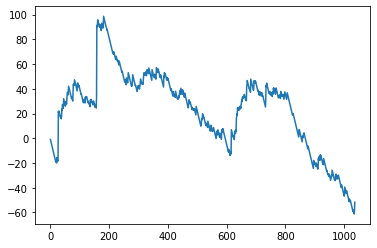

In [19]:
bets['profit'].cumsum().plot()

In [20]:
bets[['race_id', 'sub_category', 'position', 'final_odds_ref', 'pred', 'winner_dividend', 'placed_dividend', 'profit']]

,race_id,sub_category,position,final_odds_ref,pred,winner_dividend,placed_dividend,profit
0,265,COURSE_A_CONDITIONS,5.0,6.9,0.491076,0.0,0.0,-1.0
1,266,HANDICAP,2.0,15.0,0.150935,0.0,150.0,-1.0
2,267,HANDICAP,8.0,15.0,0.140620,0.0,0.0,-1.0
3,268,COURSE_A_CONDITIONS,6.0,2.3,0.170163,0.0,0.0,-1.0
4,269,COURSE_A_CONDITIONS,8.0,3.5,0.194078,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...
1032,1317,INCONNU,2.0,5.0,0.094282,0.0,190.0,-1.0
1033,1319,AUTOSTART,3.0,1.8,0.167289,0.0,150.0,-1.0
1034,1320,AUTOSTART,8.0,13.0,0.115035,0.0,0.0,-1.0
1035,1321,AUTOSTART,1.0,7.4,0.267562,430.0,160.0,3.3


When you're satisfied with the model, it's time to save it

In [21]:
import os
import shutil
from dill import dump, load

from cataclop.settings import BASE_DIR

model_dir = os.path.join(BASE_DIR, 'var/models/onboarding')

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
else:
    shutil.rmtree(model_dir)
    os.makedirs(model_dir)

path = os.path.join(model_dir, 'models.dill')
dump(models, open(path, 'wb+'))

In [22]:
import os
import shutil
from dill import dump, load

from cataclop.settings import BASE_DIR

model_dir = os.path.join(BASE_DIR, 'var/models/onboarding')

saved_models = load(open(os.path.join(model_dir, 'models.dill'), 'rb'))

In [23]:
dummies = saved_models[0]['dummies']
pipeline = saved_models[0]['pipeline']

X_val = df_validation[FEATURES]
y_test = df_validation[TARGET]
df_dummies = get_dummy_values(df_validation, dummies)
X_val = pd.concat([X_val, df_dummies], axis=1)

p = pipeline.predict(X_val)

df_validation['pred'] = p

103/103 [==============================] - 0s 763us/step


In [24]:
random_race(df_validation, ['country', 'name', 'sub_category', 'music', 'position', 'final_odds', 'pred'])

country          name sub_category         music  position  \
race_id                                                                   
189     2307     AAA  HAPPY VALLEY     HANDICAP  (20)3p0p8p0p       6.0   
        2308     AAA  HAPPY VALLEY     HANDICAP        Inédit       4.0   
        2309     AAA  HAPPY VALLEY     HANDICAP  (20)1p3p3p4p       9.0   
        2310     AAA  HAPPY VALLEY     HANDICAP  (20)6p8p0p0p      11.0   
        2311     AAA  HAPPY VALLEY     HANDICAP  (20)0p0p0p0p       5.0   
        2312     AAA  HAPPY VALLEY     HANDICAP      (20)0p4p       7.0   
        2313     AAA  HAPPY VALLEY     HANDICAP  (20)4p0p2p4p       3.0   
        2314     AAA  HAPPY VALLEY     HANDICAP  (20)0p0p0p0p       8.0   
        2315     AAA  HAPPY VALLEY     HANDICAP        Inédit      10.0   
        2316     AAA  HAPPY VALLEY     HANDICAP  (20)2p5p5p7p       1.0   
        2317     AAA  HAPPY VALLEY     HANDICAP  (20)0p9p7p8p      12.0   
        2318     AAA  HAPPY VALLEY     HANDICAP  (20)7p8p1p3p       2.0   

              final_odds      pred  
race_id                             
189     2307        9.70  0.081117  
        2308       11.00  0.024647  
        2309        5.95  0.196987  
        2310      100.00  0.074177  
        2311      175.00  0.029258  
        2312       34.00  0.042830  
        2313        2.80  0.105690  
        2314       47.00  0.042614  
        2315       44.00  0.020720  
        2316        3.55  0.178959  
        2317       44.00  0.055819  
        2318        9.60  0.105196

100%|██████████| 264/264 [00:00<00:00, 371.39it/s]


<AxesSubplot:>

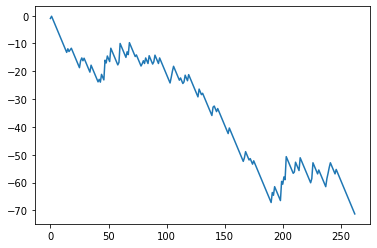

In [25]:
bets = bet(df_validation)
bets['profit'].cumsum().plot()